# Store sales Machine learning predictor for Corporation Fvorita


## Business Understanding 
### Project Description and Aim
Description:
Corporation Favorita, a leading grocery retailer in Ecuador, aims to optimize its inventory management by accurately forecasting product demand across its numerous stores. To achieve this, we are leveraging advanced machine learning techniques to develop predictive models that will forecast the unit sales for thousands of items sold at various Favorita locations. This initiative is critical for ensuring that the right quantity of products is available in stock, thereby enhancing customer satisfaction and reducing inventory costs. The project will follow the CRISP-DM (Cross-Industry Standard Process for Data Mining) framework, ensuring a structured and thorough approach to data science.

Aim:
The aim of this project is to develop a robust machine learning model that accurately predicts the unit sales of products at Corporation Favorita’s stores. By analyzing historical sales data provided by the marketing and sales teams, we will create a time series regression model that can forecast future demand. This will enable Corporation Favorita to maintain optimal inventory levels, minimize stockouts and overstock situations, and ultimately improve operational efficiency and customer satisfaction.
### Hypothesis 
Null Hypothesis (H₀):
There is no significant difference in sales patterns between stores in different  locations. Store location does not have a measurable impact on the sales performance of items sold at Corporation Favorita stores.

Alternate Hypothesis (H₁):
There is a significant difference in sales patterns between stores in different locations. Store location has a measurable impact on the sales performance of items sold at Corporation Favorita stores.
### Analytical Questions 
1. Is the train dataset complete (has all the required dates)?
2. Which dates have the lowest and highest sales for each year (excluding days the store was closed)?
3. Compare the sales for each month across the years and determine which month of which year had the highest sales.
4. Did the earthquake impact sales?
5. Are certain stores or groups of stores selling more products? (Cluster, city, state, type)
6. Are sales affected by promotions, oil prices and holidays?
7. What analysis can we get from the date and its extractable features?
8. Which product family and stores did the promotions affect.
9. What is the difference between RMSLE, RMSE, MSE (or why is the MAE greater than all of them?)
10. Does the payment of wages in the public sector on the 15th and last days of the month influence the store sales.

In [1]:
# Importing neccesary libraries for the project
# Data Manipulation and Connection
import numpy as np
import pandas as pd
import pyodbc
from dotenv import dotenv_values

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning, Preprocessing & Hyperparameter Tuning
from scipy.stats import randint, uniform
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator,TransformerMixin
from sklearn.preprocessing import OneHotEncoder, PowerTransformer, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from functools import partial
import statsmodels.api as sm
#from statsmodels.tsa.stattools import amerfeuller
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from sklearn.tree import DecisionTreeRegressor

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, make_scorer


# Model Persistence
import joblib

# Other Utilities
from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
# Load environment variables from .env file into a dictionary
environment_variables = dotenv_values('.env')


# Get the values for the credentials you set in the '.env' file
server = environment_variables.get("SERVER")
database = environment_variables.get("DATABASE")
username = environment_variables.get("USERNAME")
password = environment_variables.get("PASSWORD")

#create connection string
connection_string = f"DRIVER={{SQL Server}};SERVER={server};DATABASE={database};UID={username};PWD={password};MARS_Connection=yes;MinProtocolVersion=TLSv1.2;"

In [3]:
connection = pyodbc.connect(connection_string)

In [4]:
# 'retrieving all relevant databases for the project'
query = "Select * from dbo.oil"
oil = pd.read_sql(query, connection)

query = "Select * from dbo.holidays_events"
holiday = pd.read_sql(query, connection)

query = "Select * from dbo.stores"
stores = pd.read_sql(query, connection)

train = pd.read_csv('train.csv')

transactions = pd.read_csv('transactions.csv')

In [5]:
datasets = [oil, holiday, stores, train, transactions]
dataset_names = ['oil', 'holiday', 'stores', 'train', 'transactions']

for dataset, name in zip(datasets, dataset_names):
    print(f'--- {name} ---')
    print(dataset.head())
    print(dataset.info())
    print(dataset.isnull().sum())
    print(dataset.describe())
    print('-' * 50)

--- oil ---
         date  dcoilwtico
0  2013-01-01         NaN
1  2013-01-02   93.139999
2  2013-01-03   92.970001
3  2013-01-04   93.120003
4  2013-01-07   93.199997
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        1218 non-null   object 
 1   dcoilwtico  1175 non-null   float64
dtypes: float64(1), object(1)
memory usage: 19.2+ KB
None
date           0
dcoilwtico    43
dtype: int64
        dcoilwtico
count  1175.000000
mean     67.714366
std      25.630476
min      26.190001
25%      46.405001
50%      53.189999
75%      95.660000
max     110.620003
--------------------------------------------------
--- holiday ---
         date     type    locale locale_name                    description  \
0  2012-03-02  Holiday     Local       Manta             Fundacion de Manta   
1  2012-04-01  Holiday  Regional    Cotopaxi  Provincializaci

### Observations
1. The date columns are in column formats which is not appropriate
2. There are mostly no null values Except in the oil dataset which has 43 null values

In [6]:
# Converting date objects to datetime
oil['date'] = pd.to_datetime(oil['date'])
holiday['date'] = pd.to_datetime(holiday['date'])
train['date'] = pd.to_datetime(train['date'])
transactions['date'] = pd.to_datetime(transactions['date'])
train['date'] = pd.to_datetime(train['date'])

for data in datasets:
    print (data.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        1218 non-null   datetime64[ns]
 1   dcoilwtico  1175 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 19.2 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         350 non-null    datetime64[ns]
 1   type         350 non-null    object        
 2   locale       350 non-null    object        
 3   locale_name  350 non-null    object        
 4   description  350 non-null    object        
 5   transferred  350 non-null    bool          
dtypes: bool(1), datetime64[ns](1), object(4)
memory usage: 14.1+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 

In [7]:
# identify common colums for merging 
for dataset,name in zip(datasets,dataset_names):
    print(f'--- {name} ---')
    print(dataset.columns)

--- oil ---
Index(['date', 'dcoilwtico'], dtype='object')
--- holiday ---
Index(['date', 'type', 'locale', 'locale_name', 'description', 'transferred'], dtype='object')
--- stores ---
Index(['store_nbr', 'city', 'state', 'type', 'cluster'], dtype='object')
--- train ---
Index(['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion'], dtype='object')
--- transactions ---
Index(['date', 'store_nbr', 'transactions'], dtype='object')


In [8]:
stores.sample(10)

,store_nbr,city,state,type,cluster
46,47,Quito,Pichincha,A,14
15,16,Santo Domingo,Santo Domingo de los Tsachilas,C,3
10,11,Cayambe,Pichincha,B,6
23,24,Guayaquil,Guayas,D,1
33,34,Guayaquil,Guayas,B,6
53,54,El Carmen,Manabi,C,3
49,50,Ambato,Tungurahua,A,14
9,10,Quito,Pichincha,C,15
7,8,Quito,Pichincha,D,8
18,19,Guaranda,Bolivar,C,15


In [9]:
d1 = train.merge(stores, on='store_nbr', how='left')
d1.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 10 columns):
 #   Column       Dtype         
---  ------       -----         
 0   id           int64         
 1   date         datetime64[ns]
 2   store_nbr    int64         
 3   family       object        
 4   sales        float64       
 5   onpromotion  int64         
 6   city         object        
 7   state        object        
 8   type         object        
 9   cluster      int64         
dtypes: datetime64[ns](1), float64(1), int64(4), object(4)
memory usage: 228.9+ MB


Merging various datasets for analysis and training


In [10]:
d2 = d1.merge(transactions , on=['date' , 'store_nbr'], how='inner')

In [11]:
d3 = d2.merge(oil , on='date' , how='left')

In [12]:
merged = d3.merge(holiday , on='date' , how='left')

In [13]:
merged.head()
#change column names , check info , null and duplicates

,id,date,store_nbr,family,sales,onpromotion,city,state,type_x,cluster,transactions,dcoilwtico,type_y,locale,locale_name,description,transferred
0,561,2013-01-01,25,AUTOMOTIVE,0.0,0,Salinas,Santa Elena,D,1,770,NaN,Holiday,National,Ecuador,Primer dia del ano,False
1,562,2013-01-01,25,BABY CARE,0.0,0,Salinas,Santa Elena,D,1,770,NaN,Holiday,National,Ecuador,Primer dia del ano,False
2,563,2013-01-01,25,BEAUTY,2.0,0,Salinas,Santa Elena,D,1,770,NaN,Holiday,National,Ecuador,Primer dia del ano,False
3,564,2013-01-01,25,BEVERAGES,810.0,0,Salinas,Santa Elena,D,1,770,NaN,Holiday,National,Ecuador,Primer dia del ano,False
4,565,2013-01-01,25,BOOKS,0.0,0,Salinas,Santa Elena,D,1,770,NaN,Holiday,National,Ecuador,Primer dia del ano,False


## Data Understanding
### Exploratory Data Analysis


In [14]:
merged.rename(columns={'type_x': 'store_type'}, inplace=True)
merged.rename(columns={'type_y': 'holiday_type'}, inplace=True)

merged.info()
merged.isnull().sum()
#print(merged.describe())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2805231 entries, 0 to 2805230
Data columns (total 17 columns):
 #   Column        Dtype         
---  ------        -----         
 0   id            int64         
 1   date          datetime64[ns]
 2   store_nbr     int64         
 3   family        object        
 4   sales         float64       
 5   onpromotion   int64         
 6   city          object        
 7   state         object        
 8   store_type    object        
 9   cluster       int64         
 10  transactions  int64         
 11  dcoilwtico    float64       
 12  holiday_type  object        
 13  locale        object        
 14  locale_name   object        
 15  description   object        
 16  transferred   object        
dtypes: datetime64[ns](1), float64(2), int64(5), object(9)
memory usage: 363.8+ MB


id                    0
date                  0
store_nbr             0
family                0
sales                 0
onpromotion           0
city                  0
state                 0
store_type            0
cluster               0
transactions          0
dcoilwtico       871926
holiday_type    2346168
locale          2346168
locale_name     2346168
description     2346168
transferred     2346168
dtype: int64

### Column descriptions

1. id (int64): Unique identifier for each record in the dataset.
2. date (datetime64[ns]): The date of the recorded sales data.
3. store_nbr (int64): The store number (unique identifier for each store).
4. family (object): The category or type of product (e.g., dairy, beverages).
5. sales (float64): The total sales amount for the product family on the given date.
6. onpromotion (int64): The number of items on promotion for the product family on the given date.
7. city (object): The city where the store is located.
8. state (object): The state where the store is located.
9. store_type (object): The type of store (e.g., supermarket, hypermarket).
10. cluster (int64): The cluster/grouping of similar stores based on sales patterns and other characteristics.
11. transactions (int64): The number of transactions recorded at the store on the given date.
12. dcoilwtico (float64): The daily oil price, which could be used as an economic indicator.
13. holiday_type (object): The type of holiday (e.g., national holiday, regional holiday).
14. locale (object): The locale affected by the holiday (e.g., national, regional).
15. locale_name (object): The name of the specific locale affected by the holiday.
16. description (object): A description of the holiday or event.
17. transferred (object): Indicates if the holiday was transferred to another date.

Feature engineering


In [15]:
## creating new columns for days , months and years

merged.drop(columns = 'id', inplace=True)
merged['day'] = merged['date'].dt.day
merged['month'] = merged['date'].dt.month
merged['year'] = merged['date'].dt.year
merged['dayofweek'] = merged['date'].dt.dayofweek
merged['dayname'] = merged['date'].dt.strftime('%A')
merged.head()

,date,store_nbr,family,sales,onpromotion,city,state,store_type,cluster,transactions,...,holiday_type,locale,locale_name,description,transferred,day,month,year,dayofweek,dayname
0,2013-01-01,25,AUTOMOTIVE,0.0,0,Salinas,Santa Elena,D,1,770,...,Holiday,National,Ecuador,Primer dia del ano,False,1,1,2013,1,Tuesday
1,2013-01-01,25,BABY CARE,0.0,0,Salinas,Santa Elena,D,1,770,...,Holiday,National,Ecuador,Primer dia del ano,False,1,1,2013,1,Tuesday
2,2013-01-01,25,BEAUTY,2.0,0,Salinas,Santa Elena,D,1,770,...,Holiday,National,Ecuador,Primer dia del ano,False,1,1,2013,1,Tuesday
3,2013-01-01,25,BEVERAGES,810.0,0,Salinas,Santa Elena,D,1,770,...,Holiday,National,Ecuador,Primer dia del ano,False,1,1,2013,1,Tuesday
4,2013-01-01,25,BOOKS,0.0,0,Salinas,Santa Elena,D,1,770,...,Holiday,National,Ecuador,Primer dia del ano,False,1,1,2013,1,Tuesday


Filling missing values


In [16]:
columns_to_fill = ['holiday_type','locale','locale_name','transferred','description']

for column in columns_to_fill:
    merged[column].fillna('work day', inplace=True)

merged['dcoilwtico'].fillna(method='bfill', inplace=True)

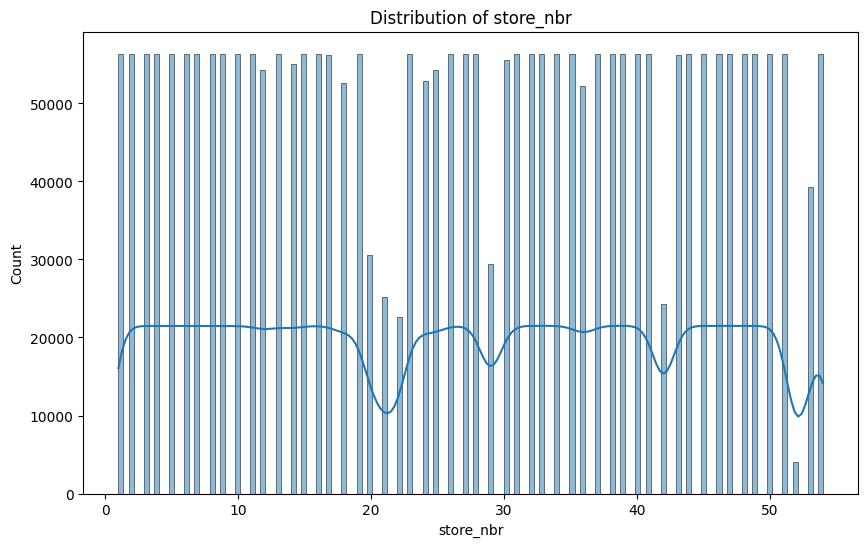

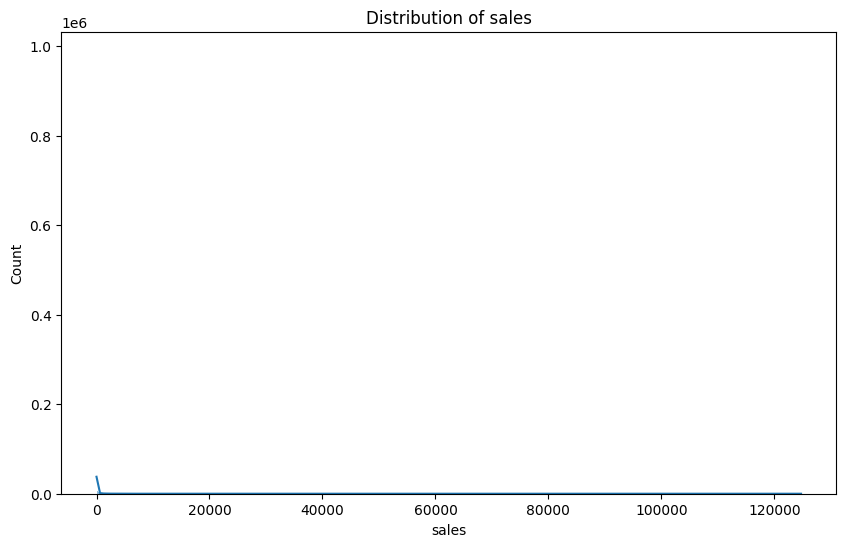

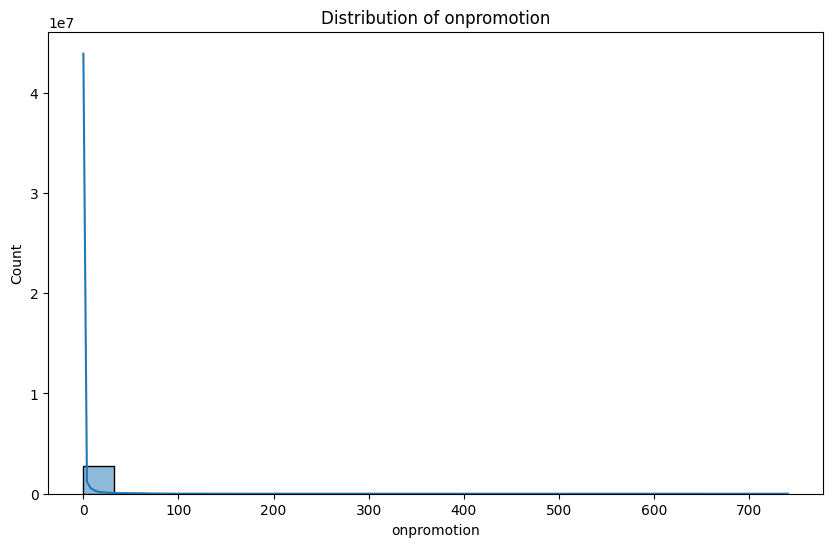

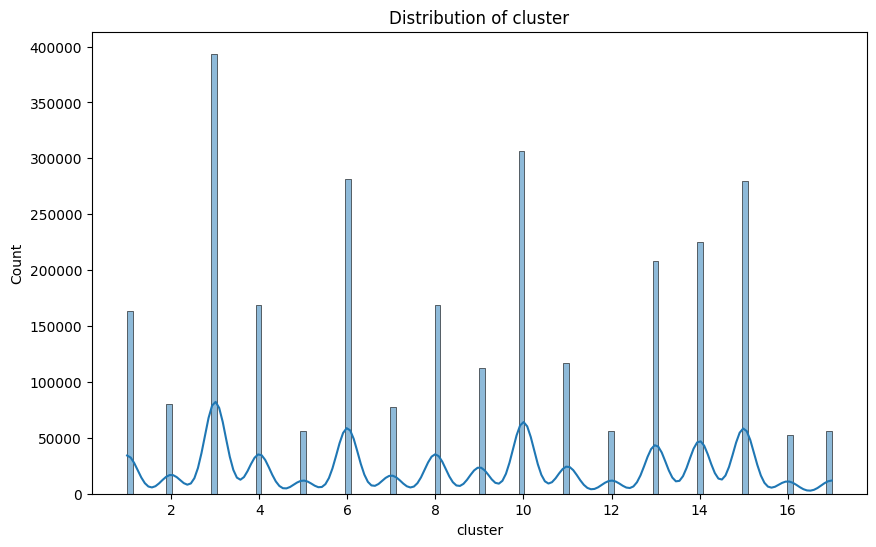

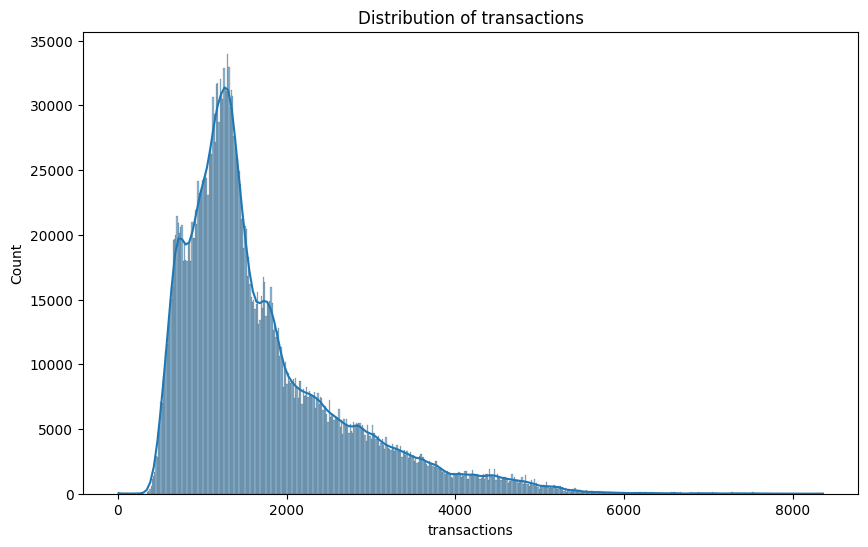

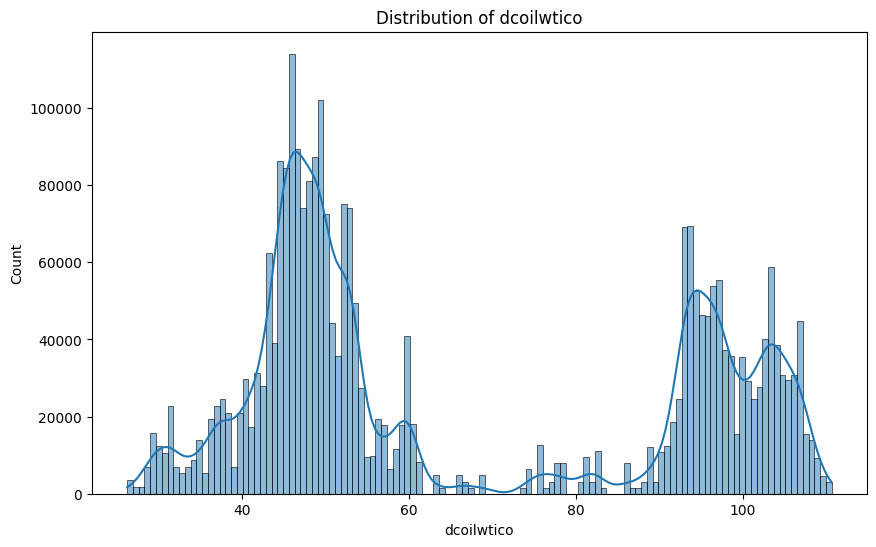

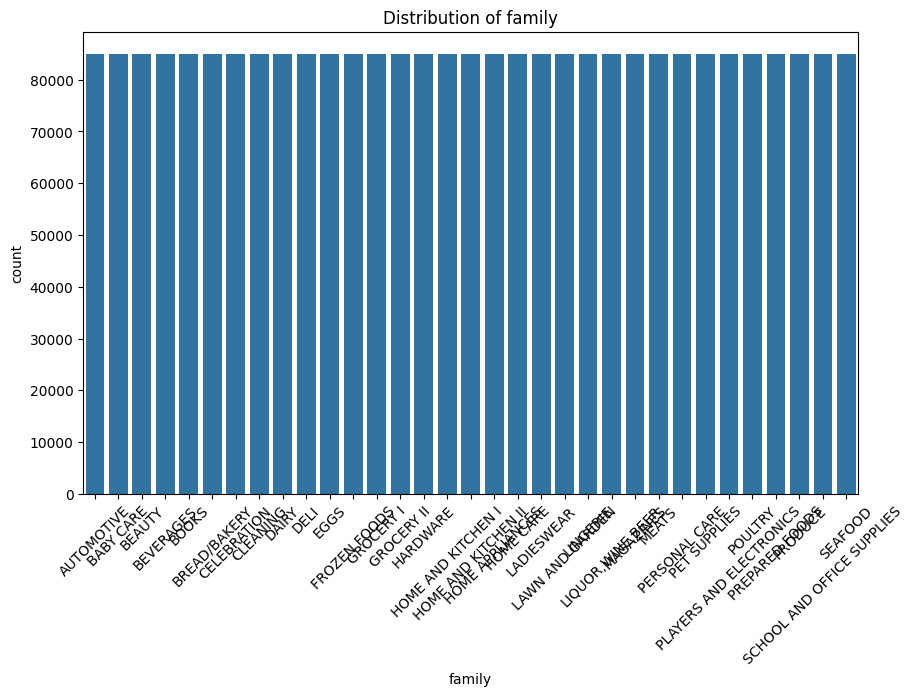

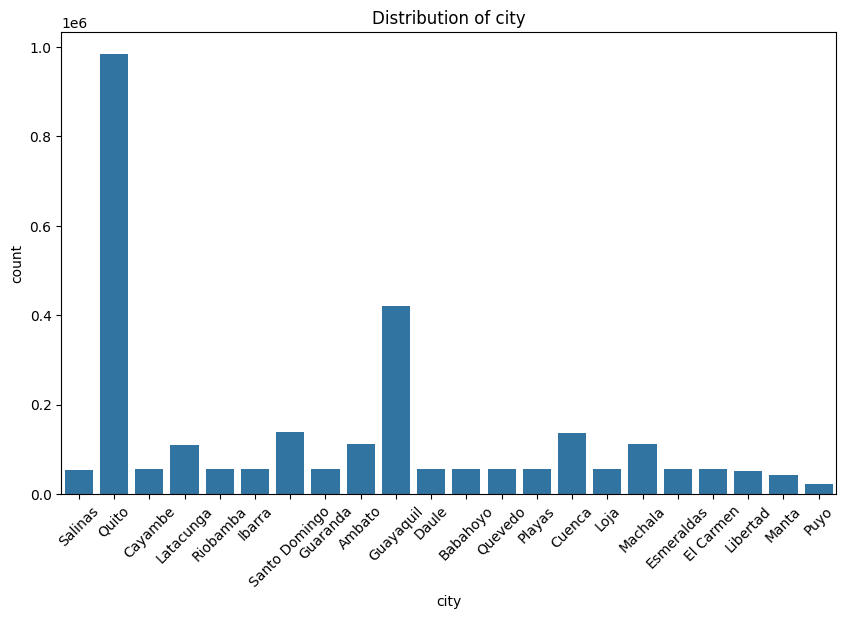

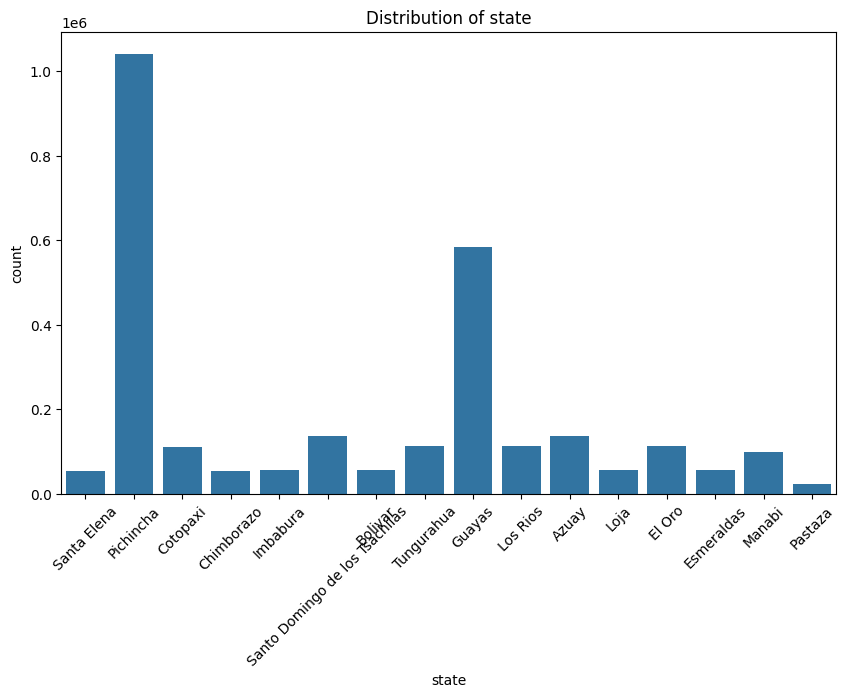

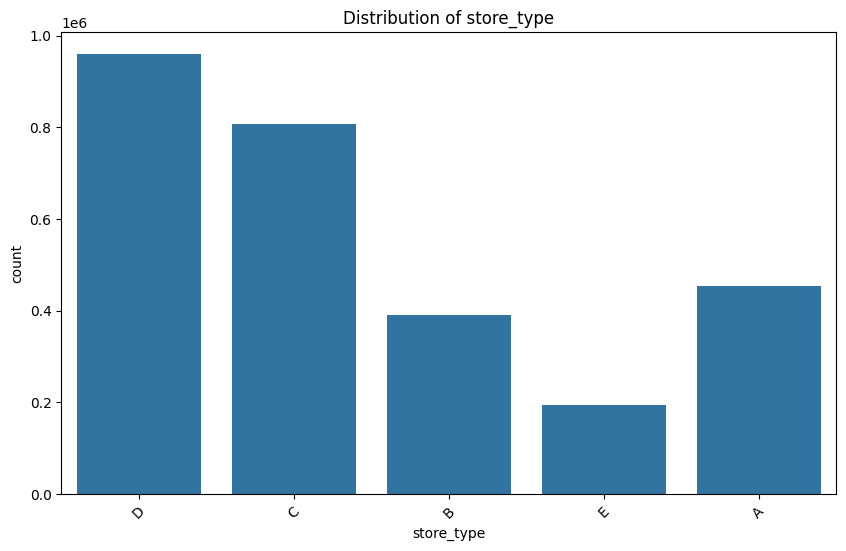

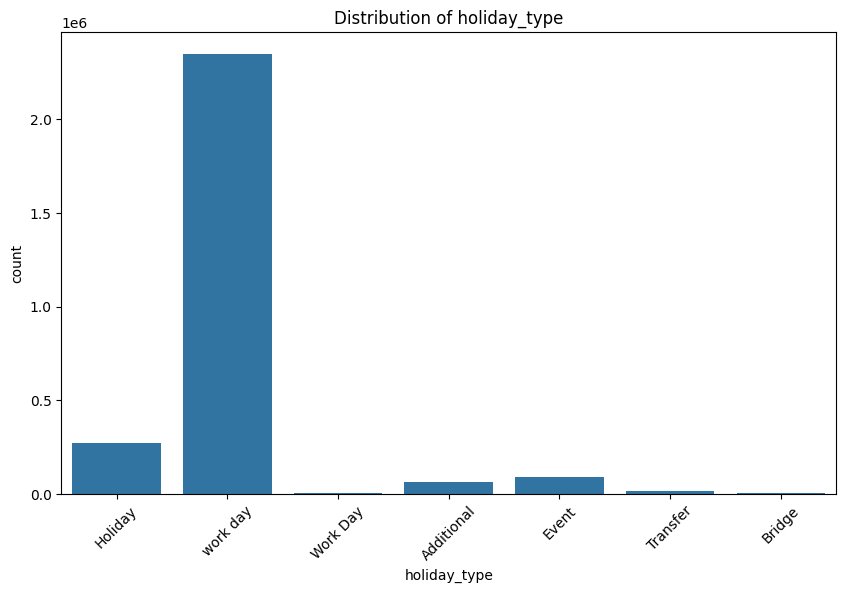

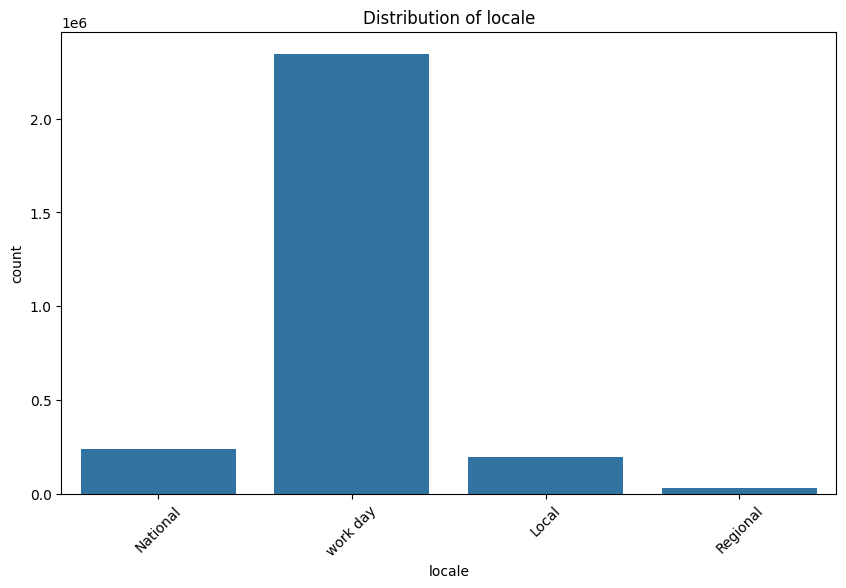

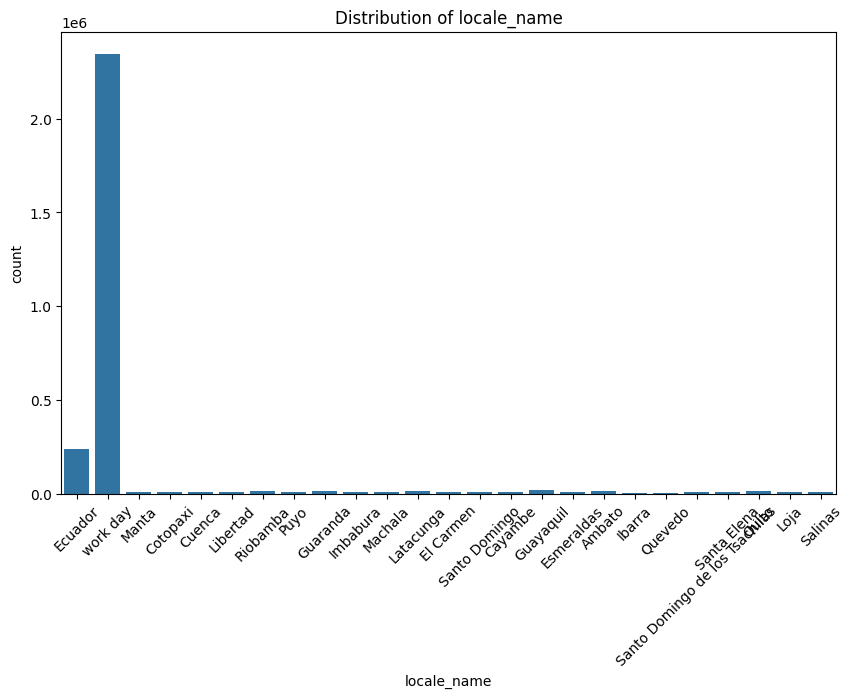

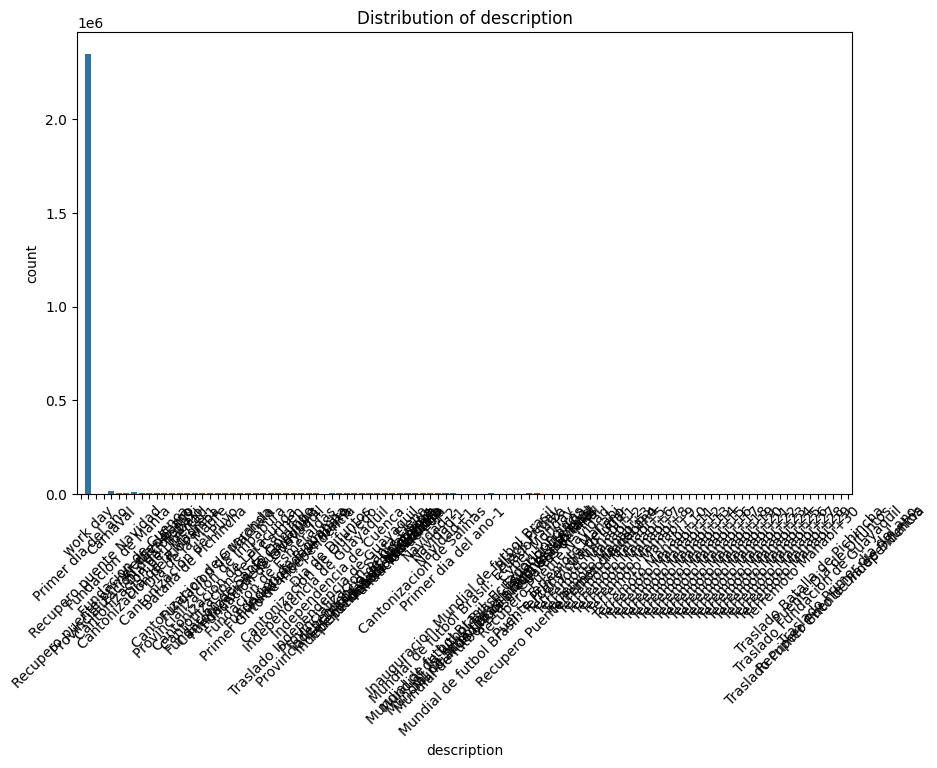

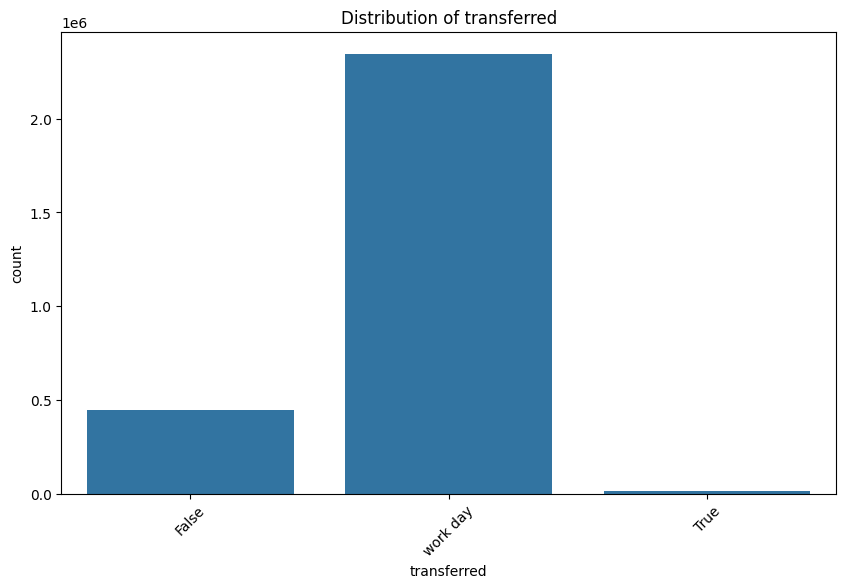

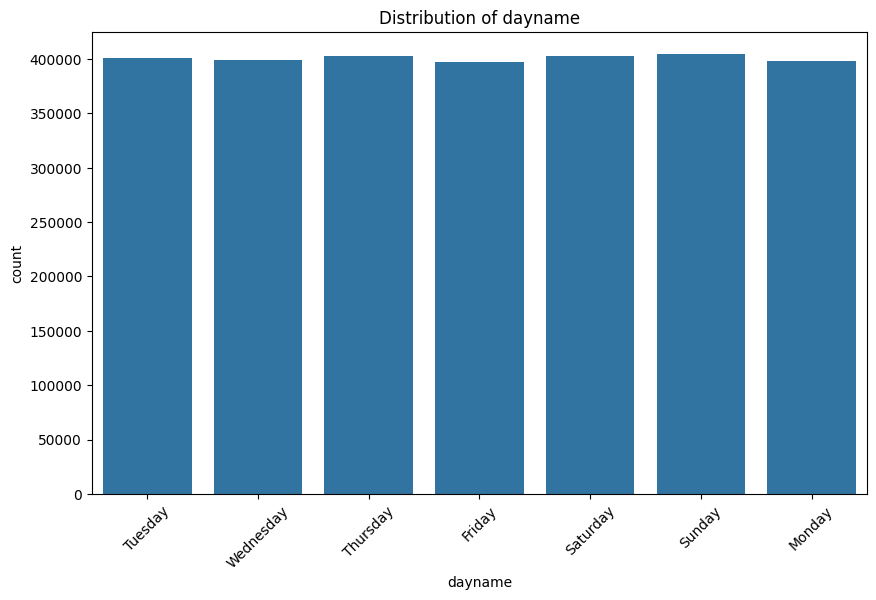

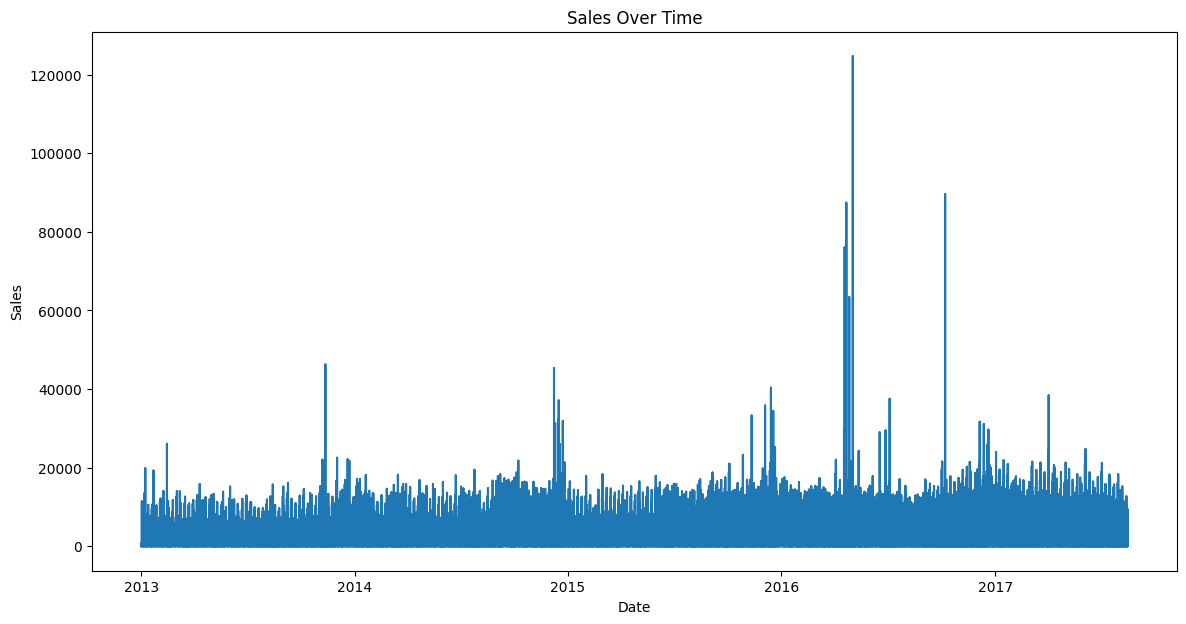

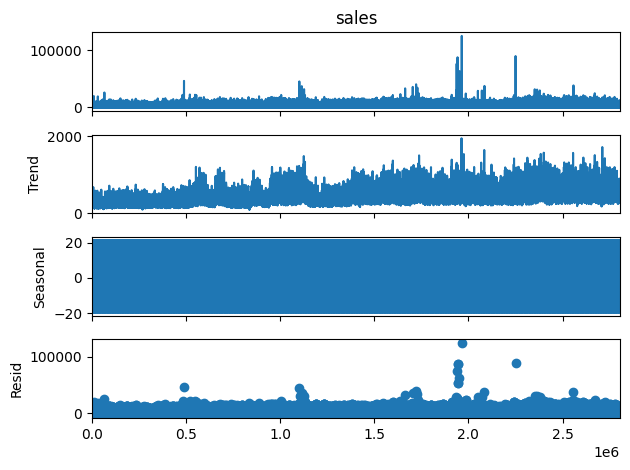

In [17]:

# Plot distribution of numeric variables
numeric_columns = merged.select_dtypes(include=['float64', 'int64']).columns
for column in numeric_columns:
    plt.figure(figsize=(10, 6))
    sns.histplot(merged[column], kde=True)
    plt.title(f'Distribution of {column}')
    plt.show()

# Plot distribution of categorical variables
categorical_columns = merged.select_dtypes(include=['object']).columns
for column in categorical_columns:
    plt.figure(figsize=(10, 6))
    sns.countplot(data=merged, x=column)
    plt.title(f'Distribution of {column}')
    plt.xticks(rotation=45)
    plt.show()

# Correlation matrix
#correlation_matrix = merged.corr()
#plt.figure(figsize=(12, 8))
#sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
#plt.title('Correlation Matrix')
#plt.show()

# Plot sales over time
plt.figure(figsize=(14, 7))
plt.plot(merged['date'], merged['sales'])
plt.title('Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

# Decompose time series components
decomposition = sm.tsa.seasonal_decompose(merged['sales'], model='additive', period=365)
fig = decomposition.plot()
plt.show()


## Answering Analytical questions

1. Is the train dataset complete (has all the required dates)?


In [18]:
# Check the range of the date column
dates_range = pd.date_range(start=merged.index.min(), end=merged.index.max())

# Check for missing dates in the dataset
missing_dates = set(dates_range.date) - set(merged.index.unique())

# Create a new dataframe with the dates_missing data
missing_dates_merged = pd.DataFrame(missing_dates)
missing_dates_merged.head()

,0
0,1970-01-01



2. Which dates have the lowest and highest sales for each year (excluding days the store was closed)?

In [19]:
# Group the data by year
grouped_data = merged.groupby('year')

# Find the dates with the highest and lowest sales for each year, excluding the dates with zero sales
years = []
max_dates = []
max_sales = []
min_dates = []
min_sales = []

for year, group in grouped_data:
    nonzero_sales_group = group[group['sales'] > 0]
    if not nonzero_sales_group.empty:
        max_sale_date = nonzero_sales_group['sales'].idxmax()
        min_sale_date = nonzero_sales_group['sales'].idxmin()
        max_sale_value = nonzero_sales_group['sales'].max()
        min_sale_value = nonzero_sales_group['sales'].min()

        years.append(year)
        max_dates.append(max_sale_date)
        max_sales.append(max_sale_value)
        min_dates.append(min_sale_date)
        min_sales.append(min_sale_value)

# Create the result DataFrame
result_data = {
    'Year': years,
    'Highest_Sales_Date': max_dates,
    'Highest_Sales': max_sales,
    'Lowest_Sales_Date': min_dates,
    'Lowest_Sales': min_sales
}
result_merged = pd.DataFrame(result_data)
result_merged

,Year,Highest_Sales_Date,Highest_Sales,Lowest_Sales_Date,Lowest_Sales
0,2013,489270,46271.000,337127,0.122
1,2014,1101849,45361.000,1097249,0.188
2,2015,1722216,40351.460,1565717,0.196
3,2016,1964601,124717.000,2061047,0.396
4,2017,2558106,38422.625,2466056,0.426


3. Compare the sales for each month across the years and determine which month of which year had the highest sales.


In [20]:
result_merged[result_merged['Highest_Sales'] ==  result_merged['Highest_Sales'].max()]


,Year,Highest_Sales_Date,Highest_Sales,Lowest_Sales_Date,Lowest_Sales
3,2016,1964601,124717.0,2061047,0.396


4. Did the earthquake impact sales?


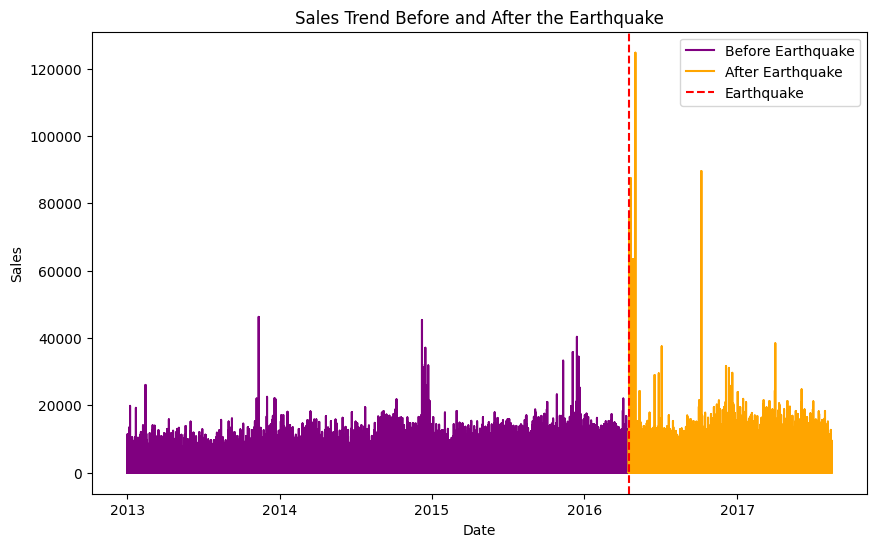

In [21]:
# Convert 'date' from index to a regular column
merged.reset_index(inplace=True)

# Filter the data for the period before and after the earthquake
before_earthquake_merged = merged[merged['date'] < '2016-04-16']
after_earthquake_merged = merged[merged['date'] >= '2016-04-16']

# Visualize the impact of the earthquake on sales
plt.figure(figsize=(10, 6))
plt.plot(before_earthquake_merged['date'], before_earthquake_merged['sales'], color='purple', label='Before Earthquake')
plt.plot(after_earthquake_merged['date'], after_earthquake_merged['sales'], color='orange', label='After Earthquake')
plt.axvline(x=pd.to_datetime('2016-04-16'), color='red', linestyle='--', label='Earthquake')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Sales Trend Before and After the Earthquake')
plt.legend()
plt.show()

# Revert 'date' back to an index
merged.set_index('date', inplace=True)

5. Are certain stores or groups of stores selling more products? (Cluster, city, state, type)

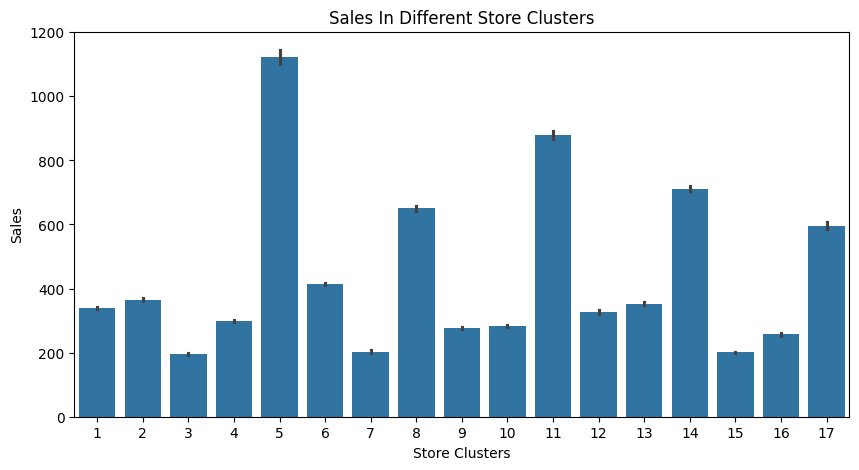

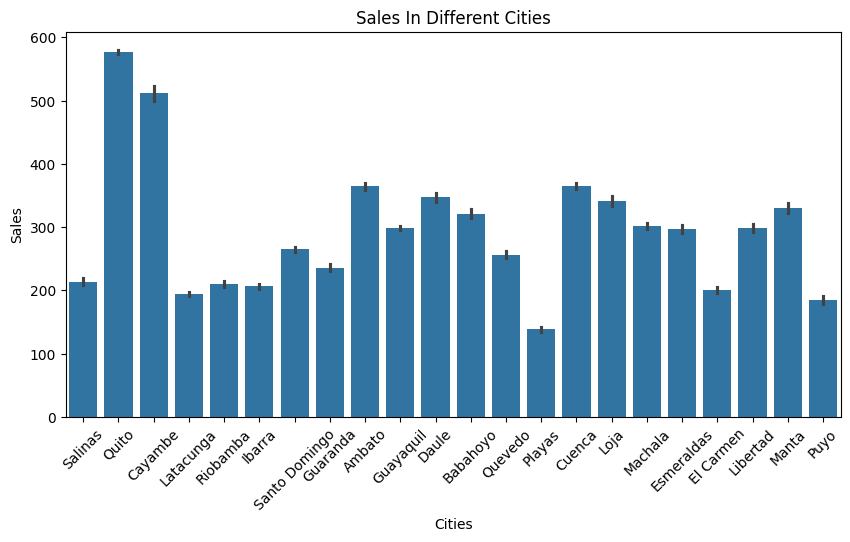

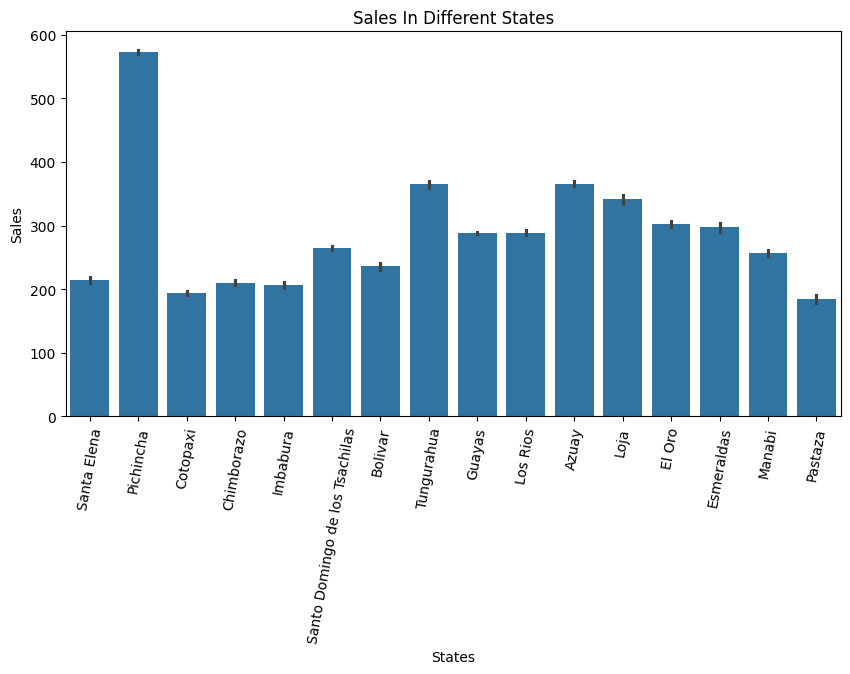

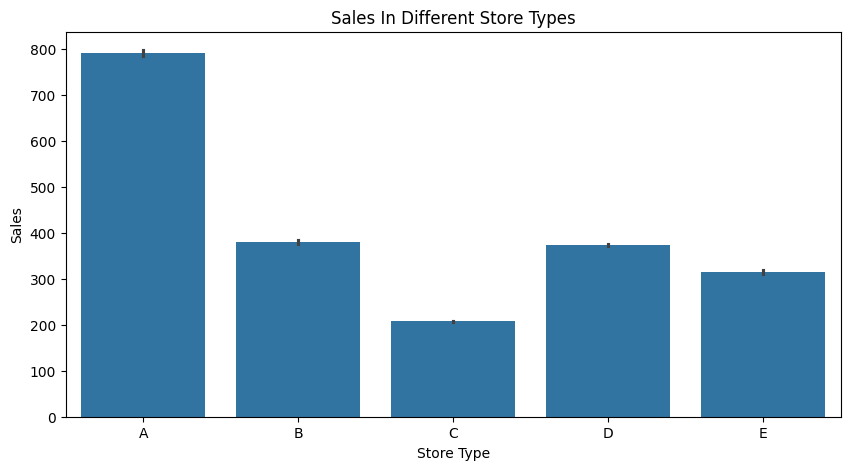

In [22]:
# Compare the sales in the different store clusters

plt.figure(figsize=(10,5))
sns.barplot(x='cluster', y='sales', data=merged)
plt.title('Sales In Different Store Clusters')
plt.xlabel('Store Clusters')
plt.ylabel('Sales')
plt.show()

# Compare the sales in different cities

plt.figure(figsize=(10,5))
sns.barplot(x='city', y='sales', data=merged)
plt.title('Sales In Different Cities')
plt.xlabel('Cities')
plt.ylabel('Sales')
plt.xticks(rotation = 45)
plt.show()

# Compare the sales in different states

plt.figure(figsize=(10,5))
sns.barplot(x='state', y='sales', data=merged)
plt.title('Sales In Different States')
plt.xlabel('States')
plt.ylabel('Sales')
plt.xticks(rotation = 80)
plt.show()

# Compare the sales in different store types

store_types = ['A', 'B', 'C', 'D', 'E']

plt.figure(figsize=(10,5))
sns.barplot(x='store_type', y='sales', data=merged, order=store_types)
plt.title('Sales In Different Store Types')
plt.xlabel('Store Type')
plt.ylabel('Sales')
plt.show()

6. Are sales affected by promotions, oil prices and holidays?

Text(0, 0.5, 'Sales')

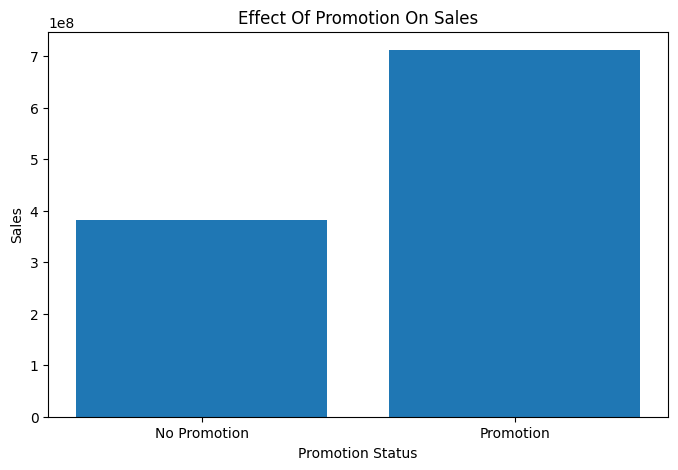

In [23]:
# Identify families with at least one item on promotion and families with no item on promotion
merged['promotion_status'] = merged['onpromotion'].apply(lambda x: 'No Promotion' if x == 0 else 'Promotion')

# Group by promotion and sum the sales
x = merged.groupby(['promotion_status'], as_index=False).agg({'sales':'sum'})

# Plot the sales of promotion and non_promotion families)
plt.figure(figsize=(8,5))
plt.bar(x.promotion_status, x.sales)
plt.title('Effect Of Promotion On Sales')
plt.xticks((0,1))
plt.xlabel('Promotion Status')
plt.ylabel('Sales')

In [24]:
merged['sales'].corr(merged['dcoilwtico'])

np.float64(-0.062340841897429396)

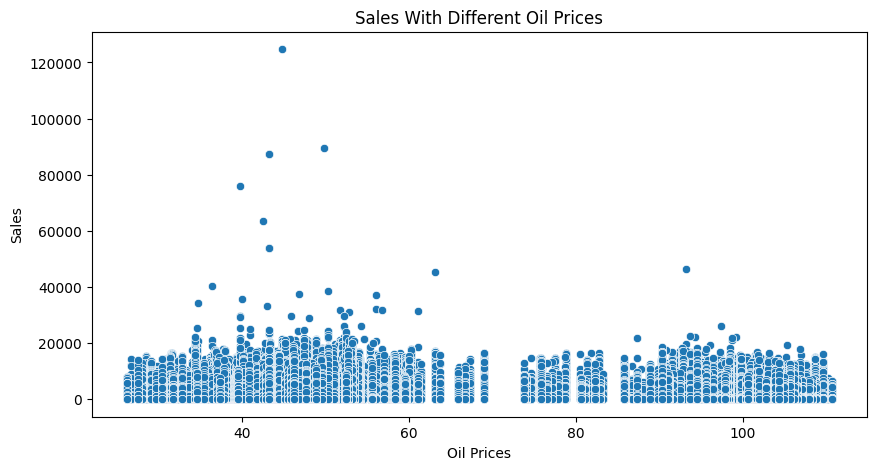

In [25]:
# Compare the sales with different oil prices

plt.figure(figsize=(10,5))
sns.scatterplot(x='dcoilwtico', y='sales', data=merged)
plt.title('Sales With Different Oil Prices')
plt.xlabel('Oil Prices')
plt.ylabel('Sales')
plt.show()

In [26]:
# Function to map holiday type to holiday status
def map_holiday_status(holiday_type):
    if holiday_type in ['No holiday', 'Work Day']:
        return 'No holiday'
    else:
        return 'Holiday'

# Add the 'holiday_status' column using the 'holiday_type' column
merged['holiday_status'] = merged['holiday_type'].apply(map_holiday_status)
merged.head()

,index,store_nbr,family,sales,onpromotion,city,state,store_type,cluster,transactions,...,locale_name,description,transferred,day,month,year,dayofweek,dayname,promotion_status,holiday_status
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,0,25,AUTOMOTIVE,0.0,0,Salinas,Santa Elena,D,1,770,...,Ecuador,Primer dia del ano,False,1,1,2013,1,Tuesday,No Promotion,Holiday
2013-01-01,1,25,BABY CARE,0.0,0,Salinas,Santa Elena,D,1,770,...,Ecuador,Primer dia del ano,False,1,1,2013,1,Tuesday,No Promotion,Holiday
2013-01-01,2,25,BEAUTY,2.0,0,Salinas,Santa Elena,D,1,770,...,Ecuador,Primer dia del ano,False,1,1,2013,1,Tuesday,No Promotion,Holiday
2013-01-01,3,25,BEVERAGES,810.0,0,Salinas,Santa Elena,D,1,770,...,Ecuador,Primer dia del ano,False,1,1,2013,1,Tuesday,No Promotion,Holiday
2013-01-01,4,25,BOOKS,0.0,0,Salinas,Santa Elena,D,1,770,...,Ecuador,Primer dia del ano,False,1,1,2013,1,Tuesday,No Promotion,Holiday


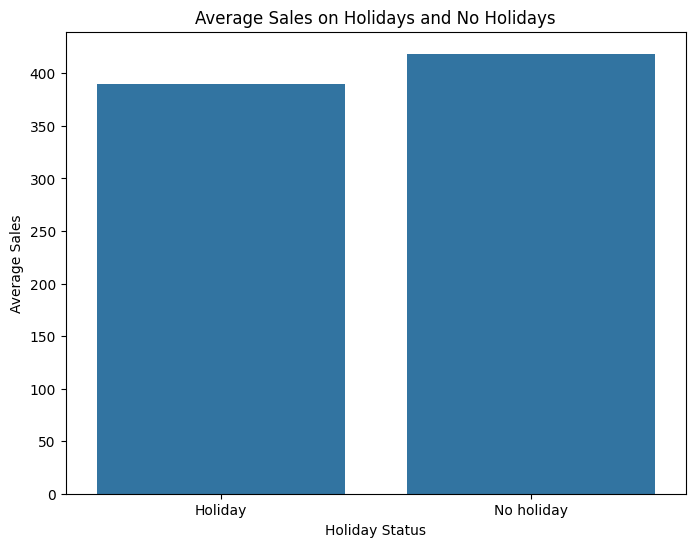

In [27]:
# Group the data by 'holiday_status' and calculate the average sales for each category
average_sales_by_holiday_status = merged.groupby('holiday_status')['sales'].mean().reset_index()

# Plot the average sales for holidays and no holidays
plt.figure(figsize=(8, 6))
sns.barplot(x='holiday_status', y='sales', data=average_sales_by_holiday_status)
plt.xlabel('Holiday Status')
plt.ylabel('Average Sales')
plt.title('Average Sales on Holidays and No Holidays')
plt.show()

7. What analysis can we get from the date and its extractable features?

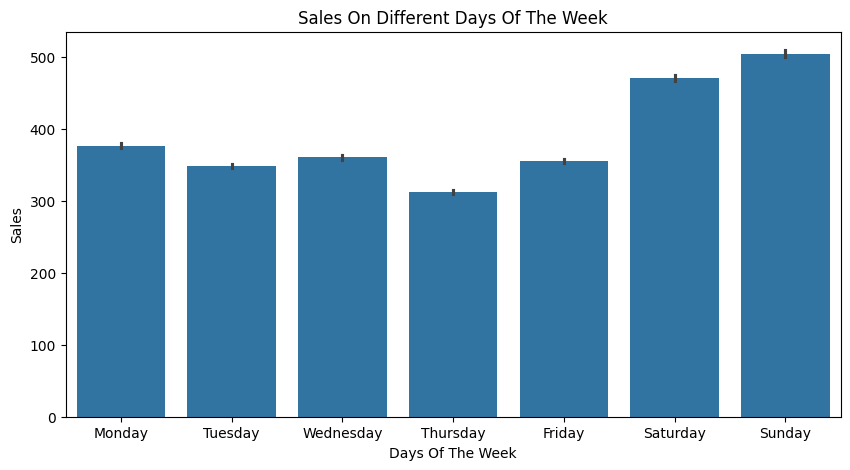

In [28]:
# From the date and its extractable features, the average sales on different days of the week can be analyzed
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

plt.figure(figsize=(10,5))
sns.barplot(x='dayname', y='sales', data=merged, order=days)
plt.title('Sales On Different Days Of The Week')
plt.xlabel('Days Of The Week')
plt.ylabel('Sales')
plt.show()

8. Which product family and stores did the promotions affect.

In [29]:
from scipy.stats import ttest_ind, boxcox, shapiro
promotion_periods = merged[merged['onpromotion'] == True].index.unique()

# Create a DataFrame to store the results
results = []

# Iterate through each store and product family
for store in merged['store_nbr'].unique():
    for family in merged['family'].unique():
        # Filter data for the specific store and family
        store_family_data = merged[(merged['store_nbr'] == store) & (merged['family'] == family)]
        
        # Calculate mean sales before, during, and after promotions
        before_promotion_sales = store_family_data[~store_family_data.index.isin(promotion_periods)]['sales']
        during_promotion_sales = store_family_data[store_family_data.index.isin(promotion_periods)]['sales']
        
        # Perform a t-test to see if the sales during promotion are significantly different from before promotion
        if len(before_promotion_sales) > 0 and len(during_promotion_sales) > 0:
            t_stat, p_value = ttest_ind(before_promotion_sales, during_promotion_sales, equal_var=False)
            results.append({
                'store_nbr': store,
                'family': family,
                'before_promotion_mean': before_promotion_sales.mean(),
                'during_promotion_mean': during_promotion_sales.mean(),
                't_stat': t_stat,
                'p_value': p_value
            })

# Convert results to DataFrame
results_merged = pd.DataFrame(results)

# Filter for significant results (e.g., p_value < 0.05)
significant_results = results_merged[results_merged['p_value'] < 0.05]

# Display significant results
print(pd.DataFrame(significant_results))


      store_nbr                      family  before_promotion_mean  \
0            25                  AUTOMOTIVE               1.597826   
1            25                   BABY CARE               0.000000   
2            25                      BEAUTY               1.650000   
3            25                   BEVERAGES            1304.539130   
4            25                       BOOKS               0.000000   
...         ...                         ...                    ...   
1546         36                     POULTRY             102.547162   
1547         36              PREPARED FOODS              42.277063   
1548         36                     PRODUCE             226.800436   
1549         36  SCHOOL AND OFFICE SUPPLIES               0.120120   
1550         36                     SEAFOOD               0.493913   

      during_promotion_mean     t_stat        p_value  
0                  2.384810  -7.219378   9.518579e-13  
1                  0.026160  -4.463795   8.8200

9. What is the difference between RMSLE, RMSE, MSE (or why is the MAE greater than all of them?)

MAE (Mean Absolute Error) measures the average absolute difference between predicted and actual values. It is less sensitive to outliers but generally larger than RMSE and MSE.

MSE (Mean Squared Error) measures the average squared difference between predicted and actual values. It gives more weight to large errors, making it sensitive to outliers.

RMSE (Root Mean Squared Error) is the square root of MSE and has the same sensitivity to outliers as MSE but is more interpretable.

RMSLE (Root Mean Squared Logarithmic Error) is useful when relative errors matter more than absolute errors and is less sensitive to outliers in the target variable.

MAE is generally greater than RMSE and MSE because it does not penalize larger errors as heavily as squared-error metrics.

10. Does the payment of wages in the public sector on the 15th and last days of the month influence the store sales?

Mean sales on payment days:  392.91037474627166
Mean sales on other days:  387.5218105984724
T-statistic for payment days vs other days:  1.9578790924615097
P-value for payment days vs other days:  0.05024550051935911
Conclusion: Sales on payment days are not significantly different from sales on other days.
Mean sales on day before payment:  375.05510003762987
T-statistic for day before payment vs other days:  -4.695995853719432
P-value for day before payment vs other days:  2.6547174117650405e-06
Conclusion: Sales on the day before payment are significantly different from sales on other days.
Mean sales on day after payment:  435.363368814082
T-statistic for day after payment vs other days:  15.311852895169286
P-value for day after payment vs other days:  6.832056505921782e-53
Conclusion: Sales on the day after payment are significantly different from sales on other days.


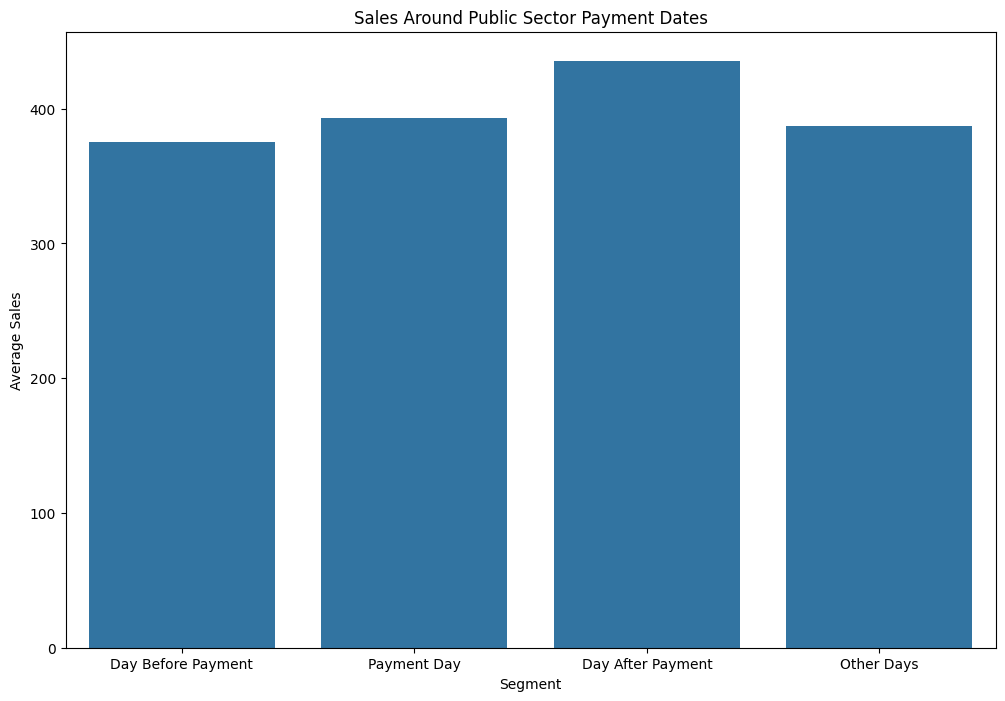

In [30]:


# Identify the 15th and last day of each month
payment_dates = merged[(merged.index.day == 15) | (merged.index.is_month_end)].index

# Extract sales data for the day before, the day of, and the day after payment dates
day_before_payment = merged[merged.index.isin(payment_dates - pd.DateOffset(days=1))]['sales']
payment_day = merged[merged.index.isin(payment_dates)]['sales']
day_after_payment = merged[merged.index.isin(payment_dates + pd.DateOffset(days=1))]['sales']

# Extract sales data for other days
other_days = merged[~merged.index.isin(payment_dates) & 
                ~merged.index.isin(payment_dates - pd.DateOffset(days=1)) & 
                ~merged.index.isin(payment_dates + pd.DateOffset(days=1))]['sales']

# Perform t-tests to see if sales on payment days are significantly different from other days
t_stat_payment, p_value_payment = ttest_ind(payment_day, other_days, equal_var=False)
t_stat_before, p_value_before = ttest_ind(day_before_payment, other_days, equal_var=False)
t_stat_after, p_value_after = ttest_ind(day_after_payment, other_days, equal_var=False)

# Display the results
print("Mean sales on payment days: ", payment_day.mean())
print("Mean sales on other days: ", other_days.mean())
print("T-statistic for payment days vs other days: ", t_stat_payment)
print("P-value for payment days vs other days: ", p_value_payment)
if p_value_payment < 0.05:
    print("Conclusion: Sales on payment days are significantly different from sales on other days.")
else:
    print("Conclusion: Sales on payment days are not significantly different from sales on other days.")

print("Mean sales on day before payment: ", day_before_payment.mean())
print("T-statistic for day before payment vs other days: ", t_stat_before)
print("P-value for day before payment vs other days: ", p_value_before)
if p_value_before < 0.05:
    print("Conclusion: Sales on the day before payment are significantly different from sales on other days.")
else:
    print("Conclusion: Sales on the day before payment are not significantly different from sales on other days.")

print("Mean sales on day after payment: ", day_after_payment.mean())
print("T-statistic for day after payment vs other days: ", t_stat_after)
print("P-value for day after payment vs other days: ", p_value_after)
if p_value_after < 0.05:
    print("Conclusion: Sales on the day after payment are significantly different from sales on other days.")
else:
    print("Conclusion: Sales on the day after payment are not significantly different from sales on other days.")

# Visualization
segments = ['Day Before Payment', 'Payment Day', 'Day After Payment', 'Other Days']
means = [day_before_payment.mean(), payment_day.mean(), day_after_payment.mean(), other_days.mean()]

plt.figure(figsize=(12, 8))
sns.barplot(x=segments, y=means)
plt.title('Sales Around Public Sector Payment Dates')
plt.xlabel('Segment')
plt.ylabel('Average Sales')
plt.show()


#### Check for stationarity 

In [31]:
#import pandas as pd
#from statsmodels.tsa.stattools import amergeduller

# Sample 10% of the data
#sampled_data = merged['sales'].dropna().sample(frac=0.1, random_state=42)

# Perform Augmented Dickey-Fuller test
#result = amergeduller(sampled_data)

#print('Amerged Statistic:', result[0])
#print('p-value:', result[1])


## Model building
#### Building a baseline model (linear regression)

In [36]:
# Create lag features
merged['lag_1'] = merged['sales'].shift(1)
merged['lag_2'] = merged['sales'].shift(2)
merged['lag_3'] = merged['sales'].shift(3)

# Drop NaN values
merged.dropna(inplace=True)

# Define features and target
X = merged[['lag_1', 'lag_2', 'lag_3']]
y = merged['sales']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the model
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Make predictions
y_pred = linear_model.predict(X_test)

# Evaluate the model
mse_lr = mean_squared_error(y_test, y_pred)
rmse_lr = np.sqrt(mse)
r2_lr = r2_score(y_test, y_pred)

print(f'Linear Regression MSE: {mse}')
print(f'Linear Regression RMSE: {rmse}')
print(f'Linear Regression R2: {r2}')


Linear Regression MSE: 1342412.9009515173
Linear Regression RMSE: 1158.625436002299
Linear Regression R2: 0.0019269971911646255


#### Building other models
1. AUTOREGRESSOR


In [37]:
# Perform first-order differencing on y_train to ensure stationarity
y_train_diff = y_train.diff().dropna()

# Determine the best lag using Akaike Information Criterion (AIC)
max_lag = 10  # Define the maximum lag order to consider
best_aic = float('inf')  # Initialize best_aic to positive infinity
best_lag = 0  # Initialize best_lag to zero

for lag in range(1, max_lag + 1):
    aic_AR_model = AutoReg(y_train_diff, lags=lag)
    aic_AR_model_fit = aic_AR_model.fit()
    aic = -2 * aic_AR_model_fit.llf + 2 * (lag + 1)  # Calculate AIC manually
    if aic < best_aic:
        best_aic = aic
        best_lag = lag

# Initialize the model with the best lag
AR_model = AutoReg(y_train_diff, lags=best_lag)

# Fit the model
AR_model_fit = AR_model.fit()

# Make predictions
AR_start = len(y_train_diff)
AR_end = len(y_train_diff) + len(y_test) - 1
AR_pred_diff = AR_model_fit.predict(start=AR_start, end=AR_end)

# Reverse the differencing for predictions to be in the original scale
# We need the last value of y_train to revert the differenced predictions
last_train_value = y_train.iloc[-1]
AR_pred = last_train_value + AR_pred_diff.cumsum()

# Calculate evaluation metrics
AR_mae = mean_absolute_error(y_test, AR_pred)
AR_mse = mean_squared_error(y_test, AR_pred)
AR_rmse = np.sqrt(AR_mse)
AR_msle = mean_squared_log_error(y_test, AR_pred)
AR_rmsle = np.sqrt(AR_msle)
AR_r2 = r2_score(y_test, AR_pred)

# Create a DataFrame for the evaluation metrics of the AR model
AR_evaluation_metrics = pd.DataFrame({
    'Model': ['AutoReg'], 
    'MAE': [AR_mae], 
    'MSE': [AR_mse], 
    'RMSE': [AR_rmse], 
    'MSLE': [AR_msle],
    'RMSLE': [AR_rmsle]
})

print(f'{AR_evaluation_metrics}')

     Model         MAE           MSE         RMSE      MSLE     RMSLE
0  AutoReg  383.620252  1.431123e+06  1196.295687  7.364293  2.713723


2. DECISION TREE REGRESSOR

In [38]:

# Create and train the model
dt_model = DecisionTreeRegressor(random_state=42)
dt_model.fit(X_train, y_train)

# Make predictions
y_pred_dt = dt_model.predict(X_test)

# Evaluate the model
mse_dt = mean_squared_error(y_test, y_pred_dt)
rmse_dt = np.sqrt(mse_dt)
r2_dt = r2_score(y_test, y_pred_dt)


In [39]:
results = {
    "Model": ["Linear Regression", "Auto Regressor", "Decision Tree"],
    "MSE": [mse_lr, AR_mse, mse_dt],
    "RMSE": [rmse_lr, AR_rmse, rmse_dt],
    "R²": [r2_lr, AR_r2, r2_dt]
}

# Create a DataFrame
results_merged = pd.DataFrame(results)

# Display the DataFrame
print(results_merged)


               Model           MSE         RMSE        R²
0  Linear Regression  1.292857e+06  1158.625436  0.001949
1     Auto Regressor  1.431123e+06  1196.295687 -0.104789
2      Decision Tree  1.129464e+06  1062.762422  0.128084
